# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter


In [2]:
print(plt.style.available)
plt.style.use('seaborn-v0_8')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
dir_path = "files/Full_Analysis"

cacheprof_BOCA = pd.read_csv(f"{dir_path}/cacheprof-BOCA-NewData-0.csv", index_col=[0])
cacheprof_GA = pd.read_csv(f"{dir_path}/cacheprof-Genetic-NewData-0.csv", index_col=[0])

grep_BOCA = pd.read_csv(f"{dir_path}/grep-BOCA-NewData-0.csv", index_col=[0])
grep_GA = pd.read_csv(f"{dir_path}/grep-Genetic-NewData-0.csv", index_col=[0])

parfib_BOCA = pd.read_csv(f"{dir_path}/parfib-BOCA-NewData-0.csv", index_col=[0])
parfib_GA = pd.read_csv(f"{dir_path}/parfib-Genetic-NewData-0.csv", index_col=[0])

sorting_BOCA = pd.read_csv(f"{dir_path}/sorting-BOCA-NewData-0.csv", index_col=[0])
sorting_GA = pd.read_csv(f"{dir_path}/sorting-Genetic-NewData-0.csv", index_col=[0])

# Iterative Ones
cacheprof_RIO =  pd.read_csv(f"{dir_path}/cacheprof-Iterative-COMPLETE-0.csv", index_col=[0])

grep_RIO = pd.read_csv(f"{dir_path}/grep-Iterative-COMPLETE-0.csv", index_col=[0])

parfib_RIO = pd.read_csv(f"{dir_path}/parfib-Iterative-COMPLETE-0.csv", index_col=[0])

sorting_RIO = pd.read_csv(f"{dir_path}/sorting-Iterative-COMPLETE-0.csv", index_col=[0])


program_tables = {"cacheprof": {"BOCA": cacheprof_BOCA, "GA": cacheprof_GA, "RIO": cacheprof_RIO}, "grep": {"BOCA": grep_BOCA, "GA": grep_GA, "RIO": grep_RIO}, "parfib": {"BOCA": parfib_BOCA, "GA": parfib_GA, "RIO": parfib_RIO}, "sorting": {"BOCA": sorting_BOCA, "GA": sorting_GA, "RIO": sorting_RIO}}

for d in program_tables.values():
    for d_name, df in d.items():
        if not (df is None):
            df.set_index("ID", inplace=True)


for d_name, d in program_tables.items():
    for type, t in d.items():
        if type == "GA":
            t.rename(columns={'Fitness': 'Runtime'}, inplace=True)

print(program_tables["cacheprof"]["GA"].count())


Mode       158
Flags      158
Runtime    158
dtype: int64


## Get best rows for each and update the dictionary

In [4]:
# Create the new dictionary to store the updated values
updated_program_tables = dict()

for program, config_dict in program_tables.items():
    updated_config_dict = dict()
    
    for config, dataframe in config_dict.items():
        if dataframe is not None:

            # Extract rows by index
            row_O0 = dataframe.loc["-O0"]
            row_O2 = dataframe.loc["-O2"]
            # Find the row with the minimum "Runtime" value
            best_row = dataframe.loc[dataframe["Runtime"].idxmin()]
            
            # Create the new dictionary for the current configuration
            updated_config = {
                "table": dataframe,
                "-O0": row_O0,
                "-O2": row_O2,
                "Best": best_row
            }
            
            updated_config_dict[config] = updated_config
    
    updated_program_tables[program] = updated_config_dict

# Now, `updated_program_tables` contains the updated dictionary as you specified.

# Analysis

## -O2 vs. -O0 vs. Optimal Preset

In [5]:

# Assuming `updated_program_tables` contains your updated dictionary

data = []
programs = list(updated_program_tables.keys())
configurations = ["BOCA", "GA", "RIO"]
columns = ["-O0", "-O2", "Optimal"]

for program in programs:
    program_data = []
    for config in configurations:
        if updated_program_tables[program][config] is not None:
            row_O0 = updated_program_tables[program][config]["-O0"]["Runtime"]
            row_O2 = updated_program_tables[program][config]["-O2"]["Runtime"]
            best_row = updated_program_tables[program][config]["Best"]["Runtime"]
            program_data.append([row_O0, row_O2, best_row])
        else:
            program_data.append([None, None, None])
    data.extend(program_data)

# Create a MultiIndex with program and configuration levels
index = pd.MultiIndex.from_product([programs, configurations], names=["Program", "Configuration"])

# print(index)
# print(data)

# Reshape data into a DataFrame
df = pd.DataFrame(data, columns=columns)


# Assign the MultiIndex
df.index = index

print(df)

                           -O0    -O2  Optimal
Program   Configuration                       
cacheprof BOCA           0.442  0.442    0.437
          GA             0.443  0.443    0.435
          RIO            2.447  2.598    2.389
grep      BOCA           0.316  0.316    0.313
          GA             0.317  0.317    0.312
          RIO            2.447  2.598    2.389
parfib    BOCA           3.493  3.493    3.490
          GA             3.652  3.652    3.571
          RIO            2.447  2.598    2.389
sorting   BOCA           0.211  0.211    0.209
          GA             0.212  0.212    0.209
          RIO            2.447  2.598    2.389


## Distribution of BOCA vs. GA vs. RIO

### Calculations for Normalization

In [6]:
normalize_around = "-O2"

for program, config_dict in updated_program_tables.items():
    for config, table_data in config_dict.items():
        if table_data is not None:
            df = table_data["table"]
            df["Norm-Z"] = (df["Runtime"] - df["Runtime"].mean()) / df["Runtime"].std()
            shift = table_data[normalize_around]["Runtime"]
            df["Norm-O2"] = (df["Runtime"] - shift) / df["Runtime"].std()

### Z-Score Normalization

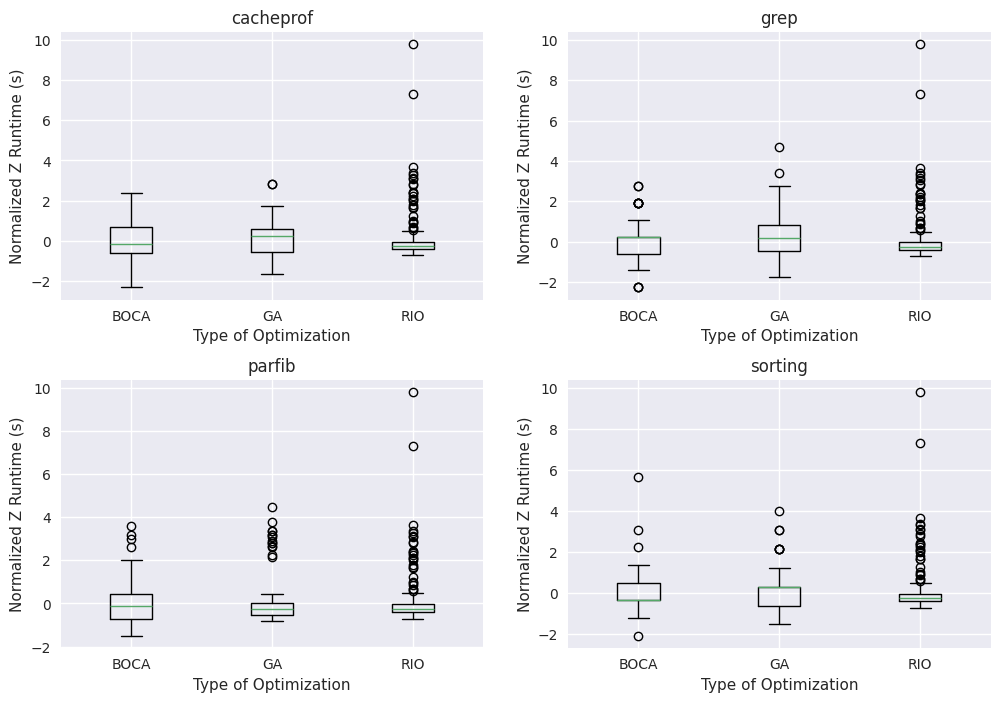

In [7]:
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)

lst1 = []
labels = []

i = 0
j = 0
for program_name, type_dict in updated_program_tables.items():
    lst1 = []
    labels = []
    for type_name, type_results in type_dict.items():
        if type_name != "IO":
            labels.append(type_name)
            df = type_results["table"]
            lst1.append(df["Norm-Z"])
    # if i == 2:
    #     i = 0
    #     if j == 2:
    #         j == 0
    #     else:
    #         j += 1
    # i += 1
    ax[i][j].boxplot(lst1)
    ax[i][j].set_xticklabels(labels)
    ax[i][j].set_ylabel(f"Normalized Z Runtime (s)")
    ax[i][j].set_xlabel(f"Type of Optimization")
    if i ==  0:
        ax[i][j].set_title(f"{program_name}", pad=20)
    ax[i][j].set_title(f"{program_name}")
    
    j = (j + 1) % 2
    if j == 0:
        i = (i + 1) % 2

plt.show()

# plt.savefig('.png')

### O2 - Normalization

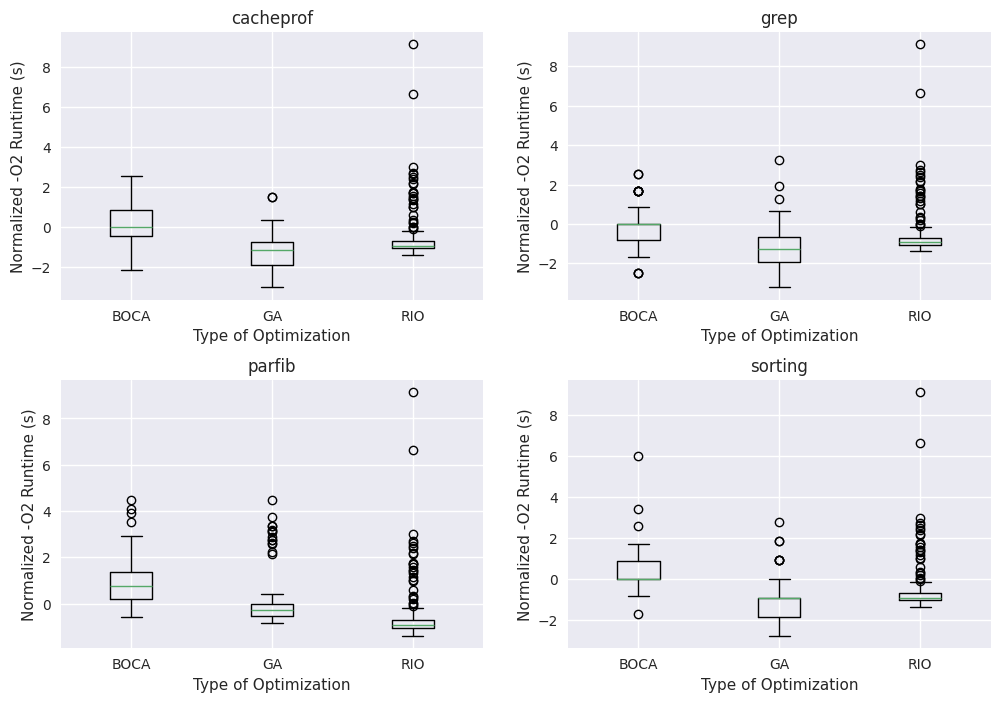

In [8]:
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)

lst1 = []
labels = []

i = 0
j = 0
for program_name, type_dict in updated_program_tables.items():
    lst1 = []
    labels = []
    for type_name, type_results in type_dict.items():
        labels.append(type_name)
        df = type_results["table"]
        lst1.append(df["Norm-O2"])


    
    ax[i][j].boxplot(lst1)
    ax[i][j].set_xticklabels(labels)
    ax[i][j].set_ylabel(f"Normalized -O2 Runtime (s)")
    ax[i][j].set_xlabel(f"Type of Optimization")
    ax[i][j].set_title(f"{program_name}")
    
    j = (j + 1) % 2
    if j == 0:
        i = (i + 1) % 2

plt.show()


## Convergence

[[58 42 63 36]
 [32 31 28 26]
 [25 18 22 17]]
{'cacheprof': {'BOCA': 58, 'GA': 32, 'Both': 25}, 'grep': {'BOCA': 42, 'GA': 31, 'Both': 18}, 'parfib': {'BOCA': 63, 'GA': 28, 'Both': 22}, 'sorting': {'BOCA': 36, 'GA': 26, 'Both': 17}}


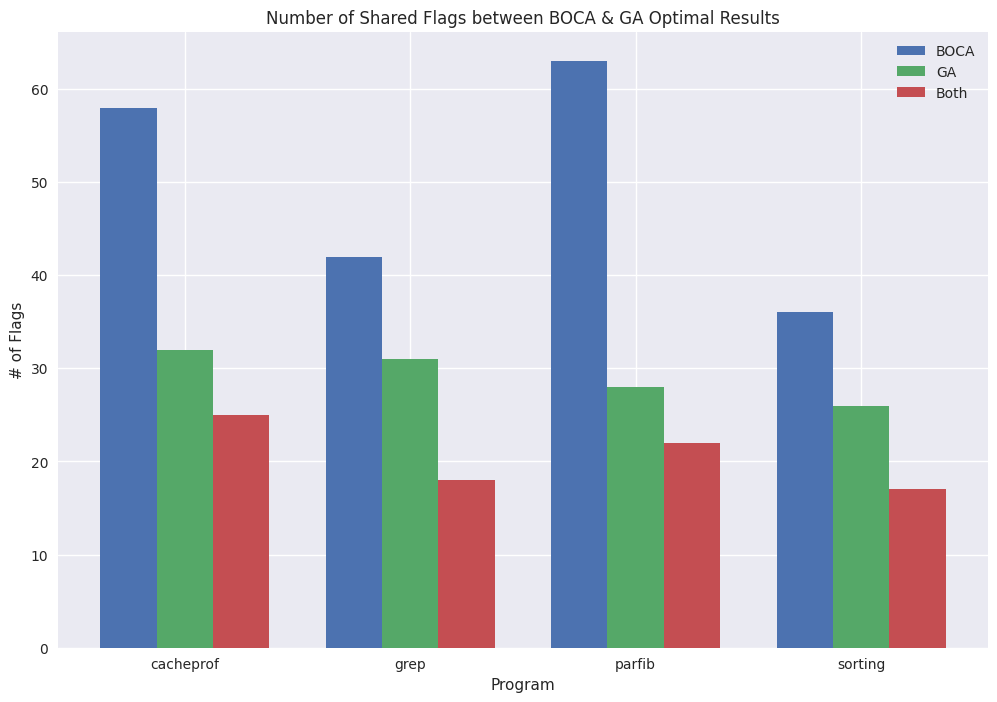

In [9]:

fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)


occuring_flags = []
labels = []

i = 0
j = 0
convergence_dict = dict()
for program_name, type_dict in updated_program_tables.items():
    occuring_flags = []
    labels = []
    for type_name, type_results in type_dict.items():
        if type_name != "RIO":
            best_flags = type_results["Best"]["Flags"]
            best_flags = eval(best_flags)[1:]
            occuring_flags.append(best_flags)
            labels.append(type_name)
            
    if len(occuring_flags) > 0:
        num_of_match = list(set(occuring_flags[0]).intersection(set(occuring_flags[1])))
        convergence_dict[program_name] = {labels[0]: len(occuring_flags[0]), labels[1]: len(occuring_flags[1]), "Both": len(num_of_match)}

programs = list(convergence_dict.keys())
configurations = list(convergence_dict["grep"].keys())
values = np.array([[convergence_dict[program][config] for program in programs] for config in configurations])

print(values)

width = 0.25
x = np.arange(len(programs))

for i, config in enumerate(configurations):
    ax.bar(x + i * width, values[i], width=width, label=config)

ax.set_xlabel('Program')
ax.set_ylabel('Number of Shared Flags')
ax.set_title('Number of Shared Flags between BOCA & GA Optimal Results')
ax.set_xticks(x + width * (len(configurations) - 1) / 2)
ax.set_xticklabels(programs)
ax.legend()

print(convergence_dict)

plt.show()
    


## Number of Required Cycles

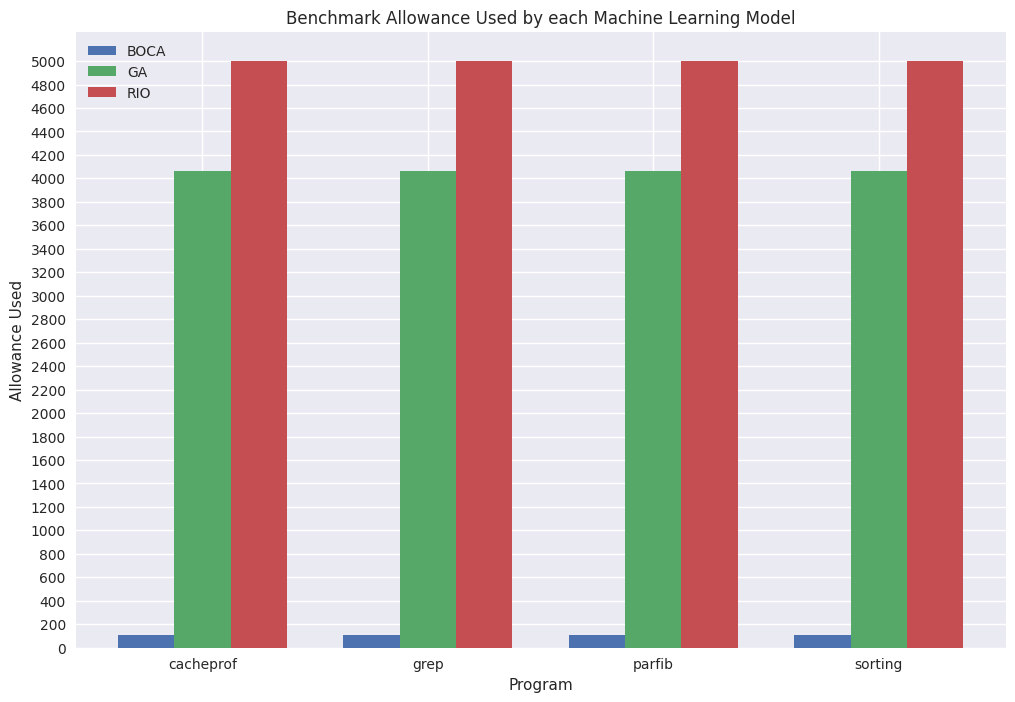

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)

programs = ["cacheprof", "grep", "parfib", "sorting"]
ml_models = ["BOCA", "GA", "RIO"]
boca_data = [106, 106, 106, 106]
ga_data = [4122, 4066, 4167, 4095]
rio_data = [5000, 5000, 5000, 5000]

data_list = [boca_data, ga_data, rio_data]

width = 0.25
x = np.arange(len(programs))

for i, config in enumerate(data_list):
    ax.bar(x + i * width, config[i], width=width, label=ml_models[i])

ax.set_xlabel('Program')
ax.set_ylabel('Allowance Used')
ax.set_title('Benchmark Allowance Used by each Machine Learning Model')
ax.set_xticks(x + width * (len(configurations) - 1) / 2)
ax.set_yticks(np.arange(0, max(max(data_list)) + 200, 200))
ax.set_xticklabels(programs)
ax.legend()


plt.show()